In [1]:
import os
import pandas as pd
import torch
from sklearn import preprocessing

def load_resistor_data(data_dir):
    # 创建一个字典来保存所有电阻和电压的数据
    data = {}
    
    # 遍历每个电压文件夹
    for voltage_folder in os.listdir(data_dir):
        voltage_path = os.path.join(data_dir, voltage_folder)
        if os.path.isdir(voltage_path):
            # 创建一个子字典来保存这个电压下的所有电阻数据
            data[voltage_folder] = {}
            
            # 遍历该电压文件夹中的所有电阻文件
            for resistor_file in os.listdir(voltage_path):
                resistor_path = os.path.join(voltage_path, resistor_file)
                if resistor_file.endswith('.csv'):
                    # 读取CSV文件到一个DataFrame中
                    resistor_data = pd.read_csv(resistor_path)
                    
                    # 将数据存入字典中
                    resistor_name = os.path.splitext(resistor_file)[0]  # 获取文件名（去掉扩展名）
                    data[voltage_folder][resistor_name] = resistor_data
                    
    return data

def scale_resistor_data(data, scalers):
    scaled_data = {}
    
    for voltage, resistors in data.items():
        scaled_data[voltage] = {}
        for resistor, df in resistors.items():
            # 只对第1列到第11列进行逐列归一化，第0列保持不变
            scaled_df = df.copy()
            min_val = scalers[resistor]['min']
            max_val = scalers[resistor]['max']
            
            for col in df.columns[1:]:  # 跳过第0列
                # 对每一列进行归一化: (x - min) / (max - min)
                scaled_df[col] = (df[col] - min_val) / (max_val - min_val)
            
            scaled_data[voltage][resistor] = scaled_df
            
    return scaled_data


def create_scalers(data):
    scalers = {}
    
    for resistor, df in data.items():
        # 计算 DataFrame 所有列的全局最小值和最大值
        min_val = df.iloc[:, 1:].min().min()  # 忽略第0列，找到所有列中的最小值
        max_val = df.iloc[:, 1:].max().max()  # 忽略第0列，找到所有列中的最大值

        # 将 min_val 和 max_val 存储为字典的值
        scalers[resistor] = {'min': min_val, 'max': max_val}
        
    return scalers

    


def concatenate_resistor_data(data):
    concatenated_data = {}
    
    # 遍历所有电压和电阻，将同一个电阻的数据进行拼接
    for voltage, resistors in data.items():
        for resistor, df in resistors.items():
            if resistor not in concatenated_data:
                concatenated_data[resistor] = df.copy()
            else:
                concatenated_data[resistor] = pd.concat([concatenated_data[resistor], df], ignore_index=True)
    
    return concatenated_data

# 假设数据位于 /data/ 目录中
data_dir = 'C:\\Users\\walter\\OneDrive\\桌面\\收集\\2024大數據競賽\\2024-pre-train'
resistor_data = load_resistor_data(data_dir)

# 第二步：拼接相同电阻的所有电压数据
concatenated_resistor_data = concatenate_resistor_data(resistor_data)

# 第三步：为每个电阻的每列数据创建并拟合 MinMaxScaler
minmax_scalers = create_scalers(concatenated_resistor_data)

# 第四步：使用拟合好的 MinMaxScaler 对每个电阻数据进行标准化
minmax_resistor_data = scale_resistor_data(resistor_data, minmax_scalers)

# 查看读取的数据结构
for voltage, resistors in resistor_data.items():
    print(f"Voltage: {voltage}")
    for resistor, df in resistors.items():
        print(f"  Resistor: {resistor}, Data shape: {df.shape}")
        print("df", df)

# 查看读取的数据结构
for voltage, resistors in minmax_resistor_data.items():
    print(f"Voltage: {voltage}")
    for resistor, df in resistors.items():
        print(f"  Resistor: {resistor}, Data shape: {df.shape}")
        print("df", df)


Voltage: 1
  Resistor: a, Data shape: (4000, 11)
df         id   y01   y02   y03   y04   y05   y06   y07   y08   y09   y10
0        1  1072  1015  1024  1116  1196  1194  1190  1196  1214  1181
1        2  1072  1015  1024  1115  1194  1193  1189  1194  1212  1180
2        3  1070  1015  1023  1113  1190  1189  1185  1192  1209  1177
3        4  1067  1014  1021  1111  1187  1186  1182  1188  1205  1174
4        5  1065  1012  1020  1108  1184  1183  1179  1185  1202  1170
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
3995  3996   836   840   843   839   840   836   835   840   839   841
3996  3997   836   840   843   839   840   836   835   840   839   841
3997  3998   836   840   843   839   840   837   835   840   839   841
3998  3999   836   840   843   839   840   837   835   840   839   841
3999  4000   836   840   843   839   841   836   835   839   839   841

[4000 rows x 11 columns]
  Resistor: b, Data shape: (4000, 11)
df         id   y01   y02   y03 

In [2]:

print(f"test target output: {resistor_data['13']['a'].iloc[:50, 1]}")



test target output: 0     442
1     440
2     436
3     432
4     429
5     425
6     421
7     417
8     414
9     411
10    408
11    404
12    401
13    397
14    394
15    391
16    388
17    385
18    381
19    378
20    375
21    372
22    369
23    366
24    363
25    360
26    357
27    354
28    351
29    348
30    345
31    342
32    339
33    337
34    334
35    331
36    328
37    326
38    324
39    321
40    319
41    316
42    314
43    311
44    309
45    307
46    304
47    302
48    300
49    297
Name: y01, dtype: int64


# 模型
##### 子模型1

In [3]:
import torch
import torch.nn as nn

class ResistancePredictor(nn.Module):
    def __init__(self):
        super(ResistancePredictor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(16 * 50 , 128)
        self.fc2 = nn.Linear(128, 100)
        self.r=nn.LeakyReLU()
    def forward(self, x):
        #print("x",x.shape)
        x = x.permute(1, 0).unsqueeze(0)  # 先 permute 然後 unsqueeze
        #print("x",x.shape)
       
        x = torch.relu(self.bn1(self.conv1(x)))
        #print("x",x.shape)

        x = x.view(x.size(0), -1)
        #print("x",x.shape)

        x = self.r(self.fc1(x))
        #print("x",x.shape)

        resistance = self.fc2(x)
        resistance=resistance.view(-1)
        #print("resistance",resistance.shape)

        return resistance



##### 子模型2

##### 合併

In [4]:
device = torch.device("cuda:0")

class LstmRNN(nn.Module):
    """
        Parameters：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
 
    def __init__(self, input_size, hidden_size, output_size, num_layers,dropout_rate,timeLong):
        super().__init__()
 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,dropout=dropout_rate)  # utilize the LSTM model in torch.nn
        self.timeLong=timeLong
        self.dropout = nn.Dropout(p=dropout_rate)
        self.temp_network = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(1000 , 128),  # 將 temp 進一步壓縮或轉換
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 50)

        )
        self.temp_w=nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(50, 5)


        )

        # 獨立處理 resistance 的小型網絡
        self.resistance_network = nn.Sequential(
            nn.Linear(100, 50),  # 將 resistance 昇華到與其他特徵相當的表示能力
            nn.ReLU()
        )
        self.resistance_w=nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(50, 5)


        )

        self.i_network = nn.Sequential(
            nn.Linear(int(timeLong), 25),  # 將 resistance 昇華到與其他特徵相當的表示能力
            nn.ReLU()
        )
        self.i_w=nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(25, 5)


        )
        # 獨立處理 one_hot_tensor 的小型網絡
        self.one_hot_network = nn.Sequential(
            nn.Linear(10, 2),  # 將 one_hot_tensor 轉換為相同的表示維度
            nn.ReLU()
        )
        
        # 用於學習加權融合的線性層
        self.weight_network = nn.Linear(5+5+5+2, 4)  # 為三個處理後的特徵學習三個權重
        self.dropout = nn.Dropout(p=dropout_rate)  # dropout训练

        # 最終輸出的線性層
        self.res = nn.Linear(50+50+25+2, 50)
        self.resistance_add=nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(100, 50),  # 將 resistance 昇華到與其他特徵相當的表示能力
            nn.Dropout(p=dropout_rate),
            nn.Linear(50, 1),  # 將 resistance 昇華到與其他特徵相當的表示能力
            nn.ReLU())        
    def forward(self, _x,resistance,j,i):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        #print("x",x.shape)

        x = x[:, -1, :]  # 取LSTM最後一個時間步的輸出，形狀為 (batch_size, hidden_size)
        #print("x",x.shape)
        x = x.flatten()  # 或者使用 res.flatten()
        #print("x",x.shape)
        # 獨立處理 temp, resistance 和 one_hot_tensor
        x_processed = self.temp_network(x)
        resistance_processed = self.resistance_network(resistance)
        i = torch.tensor(np.arange(i, i + self.timeLong), dtype=torch.float32, device='cuda:0', requires_grad=True)
        i_processed =self.i_network(i)
        one_hot_tensor = torch.zeros(10, device=x.device)
        one_hot_tensor[j-1] = 1
        one_hot_processed = self.one_hot_network(one_hot_tensor)
        #調整網路
        tw=self.temp_w(x_processed)
        rw=self.resistance_w(resistance_processed)
        iw=self.i_w(i_processed)
        # 合併三個處理後的特徵
        combined_features = torch.cat((tw, rw, one_hot_processed,iw), dim=-1)
        combined_features=self.dropout(combined_features)
        # 使用 weight_network 來學習 temp, resistance 和 one_hot_tensor 的權重
        weights = torch.softmax(self.weight_network(combined_features), dim=-1)
        
        # 加權融合特徵
        weighted_x = weights[0] * x_processed
        weighted_resistance = weights[1] * resistance_processed
        weighted_one_hot = weights[2] * one_hot_processed
        weightted_i=weights[3] * i_processed
        # 最終特徵融合
        final_combined = torch.cat((weighted_x, weighted_resistance, weighted_one_hot,weightted_i), dim=-1)
        final_combined=self.dropout(final_combined)
        r_add=self.resistance_add(resistance)

        # 通過線性層進行處理
        output = self.res(final_combined)
        output=output+r_add
        return output



In [5]:
device = torch.device("cuda:0")

def create_sequences(data, sequence_length):
    xs, ys = [], []
    #print("data len",len(data))
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length]
        #print("in x",x)
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)


class CompleteModel(nn.Module):
    def __init__(self):
        super(CompleteModel, self).__init__()
        self.resistance_predictor = ResistancePredictor()
        """
        :param vocab_size: 词典长度
        :param pkernel_size: 池化层kernel宽度
        :param embedding_dim: 词向量维度
        :param kernel_size: 卷积池kernel宽度
        :param hidden_dim: LSTM神经元的个数
        :param layer_dim: LSTM层数
        :param output_dim: 隐藏层的输出维度（分类的数量）
        """

                
        self.timeLong = 50
        # 定义LSTM超参数
        input_size = 1   # 输入特征维度
        hidden_size = 50  # 隐藏单元数量
        num_layers = 1   # LSTM层数
        self.output_size = 50  # 输出类别数量
        dropout_rate=0.4

        self.sequence_length = 30

        self.vocab_size=50
        self.embedding_dim=self.timeLong-self.sequence_length
        self.kernel_size=2
        self.pkernel_size=2

        self.conv = nn.Sequential(
                nn.Conv1d(in_channels=self.embedding_dim,
                          out_channels=self.embedding_dim,
                          kernel_size=self.kernel_size),
                nn.BatchNorm1d(self.embedding_dim),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(kernel_size=(self.pkernel_size))
        )
        


        self.lstm = LstmRNN(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,output_size=self.output_size,dropout_rate=dropout_rate,timeLong=self.timeLong)
    
    def forward(self, bcd_input, target_input,j,mode = 'train'):

        if mode == 'train':
            resistance = self.resistance_predictor(bcd_input)

            # 确保输出张量初始化时在正确的设备上
            output = torch.empty(4000)

            for i in range(0,4000-self.timeLong,int(self.output_size/2)):
                
                temp = target_input[i:i+self.timeLong]
                x,y=create_sequences(data=temp,sequence_length=self.sequence_length)
                #print("x shape",x.shape)

                ## embeds shape (batch,sent_long,embedding_dim)

                x = x.view(1, self.timeLong-self.sequence_length, self.sequence_length)  # (batch_size=1, sequence_length=5, input_size=50)
                #x = x.permute(0, 2, 1)

                #print("x shape",x.shape)

               
                ## embeds shape (batch,embedding_dim,sent_long)
                conved = self.conv(x)
                #conved torch.Size([1, 40, 4])
                #print("conved",conved.shape)

                ## conved shape (batch,embedding_dim,(sent_long-kernel_size+1)/pkernel_size)
                conved = conved.permute(1, 2, 0)
                ## embeds shape (batch,embedding_dim,sent_long)
                #print("conved shape",conved.shape)
                ## 这里lstmcell的输入维度要调整为embedding_dim，文本在时间上展开成一个个embedding向量，这样才是把文本作为序列信息处理
                res = self.lstm(_x=conved,resistance=resistance,j=j,i=i)

                
                #print("res ",res)
                res = res.view(-1)  # 或者使用 res.flatten()
                res_temp=res[int(self.output_size/2):]
                # 将结果拼接到 data 中

                if i == 50:
                    output[i+self.timeLong:i+self.timeLong+int(self.output_size/2)] = res[:int(self.output_size/2)]

                elif i == 4000-int(self.output_size/2):
                    output[i+self.timeLong:i+self.timeLong+int(self.output_size/2)] = res[int(self.output_size/2):]
                else:
                    output[i+self.timeLong:i+self.timeLong+int(self.output_size/2)] = (res[:int(self.output_size/2)]+res_temp)/2

            
            
            output = output.to(device)
            #print("output shape",output.shape)
            return output[50:]
        
        elif mode == 'test':
            resistance = self.resistance_predictor(bcd_input)
            
            for i in range(50, 4000, int(self.output_size/2)):
                temp = target_input[-self.timeLong:]
                x,y=create_sequences(data=temp,sequence_length=self.sequence_length)
                ## embeds shape (batch,sent_long,embedding_dim)

                x = x.view(1, self.timeLong-self.sequence_length, self.sequence_length)  # (batch_size=1, sequence_length=5, input_size=50)



                ## embeds shape (batch,embedding_dim,sent_long)
                conved = self.conv(x)
                #conved torch.Size([1, 10, 4])
                #print("conved",conved.shape)

                ## conved shape (batch,embedding_dim,(sent_long-kernel_size+1)/pkernel_size)
                conved = conved.permute(1, 2, 0)
                #print("conved",conved)

                ## conved shape (batch,embedding_dim,(sent_long-kernel_size+1)/pkernel_size)
                #print("conved shape",conved.shape)
                ## 这里lstmcell的输入维度要调整为embedding_dim，文本在时间上展开成一个个embedding向量，这样才是把文本作为序列信息处理
                res= self.lstm(_x=conved,resistance=resistance,j=j,i=i)

                res = res.view(-1)  # 或者使用 res.flatten()
                res_temp=res[:int(self.output_size/2)]
                if i == 50:
                    target_input = torch.cat((target_input, res[:int(self.output_size/2)]), dim=0)
                elif i == 4000-int(self.output_size/2):
                    target_input = torch.cat((target_input, res[int(self.output_size/2):]), dim=0)
                else:
                    target_input = torch.cat((target_input, (res[:int(self.output_size/2)] + res_temp) / 2), dim=0)
            #print("target_input shape",target_input.shape)

            #print("target_input shape",target_input.shape)

            return target_input[50:]

        '''
        for i in range(79):

            temp = target_input[-self.timeLong:]
            #print('temp size',temp.size())
            # 将 resistance_predictor 拼接到 temp 中
            
            # 通过 resmodel 模型预测
            res = self.res(temp)
            #print('temp',temp)
            # 将结果拼接到 data 中
            target_input = torch.cat((target_input, res), dim=0)
        return target_input[50:]
        '''

In [6]:
def inverse_minmax_scaler(scaled_tensor, min_val, max_val):
    # 手动实现 MinMaxScaler 的逆变换
    original_tensor = scaled_tensor * (max_val - min_val) + min_val
    return original_tensor
# 将 min_val 和 max_val 转移到 GPU 上
min_val = torch.tensor(minmax_scalers['a']['min']).to(device)
max_val = torch.tensor(minmax_scalers['a']['max']).to(device)


In [7]:
'''
import torch
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_peak_memory_stats()

# 打印当前 GPU 内存使用情况
print(torch.cuda.memory_summary())

import torch
torch.cuda.set_per_process_memory_fraction(0.9)  # 限制 GPU 內存使用率為 80%
torch.cuda.empty_cache()

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
'''
print(torch.cuda.memory_summary())


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1024 B  |    1024 B  |    1024 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |    1024 B  |    1024 B  |    1024 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |    1024 B  |    1024 B  |    1024 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

# 訓練

In [8]:
import torch.optim as optim
from torch.nn import init
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.cuda.amp import autocast, GradScaler

# 清空 CUDA 缓存以释放未使用的显存
torch.cuda.empty_cache()

scaler = GradScaler()
type = 'a'

# 建立模型
model = CompleteModel()
device = torch.device("cuda:0")

# 初始化网络参数
for params in model.parameters():
    init.normal_(params, mean=0, std=0.01)

print(model)

# 定义损失函数和优化器
criterion = nn.MSELoss()

#optimizer = optim.Adam(model.parameters(), lr=0.05)
optimizer = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=8, factor=0.7, verbose=True)

num_epochs = 1000
all_train_loss = []
all_test_loss = []
model = model.to(device)


graph_epoch = 10
x = np.linspace(start=50, stop=4000, num=3950)
voltage_w={
    '1':1500,'2':750,'3':200,'4':80,'5':30,'6':4,'7':1,'8':4,'9':30,'10':80,'11':200,'12':750,'13':1500
}
for epoch in range(num_epochs):
    start = time.time()

    trl=[]
    tel=[]

    for test_voltage in range(1, 13):
        v_trl=[]

        test_voltage = str(test_voltage)
        for voltage in range(1, 13):
            

            voltage = str(voltage)
            temp_test=[]

            #train
            if voltage!=test_voltage:
                model.train()
                input_1 = resistor_data[voltage][type].iloc[:50, 1:11].to_numpy()
                input_1 = torch.from_numpy(input_1).float().to(device)
                temp_train=[]

                for j in range(0, 11):
                    input_2 = resistor_data[voltage][type].iloc[:, j].to_numpy()
                    input_2 = torch.from_numpy(input_2).float().to(device)

                    target_out = resistor_data[voltage][type].iloc[50:, j].to_numpy()
                    target_out = torch.from_numpy(target_out).float().to(device)

                    optimizer.zero_grad()

                    # 使用 autocast 开始自动混合精度
                    
                    # 前向传播
                    outputs = model(input_1, input_2, mode='train', j=j)
                    #outputs_denorm = inverse_minmax_scaler(outputs, min_val, max_val)
                    loss = torch.sqrt(criterion(outputs, target_out))

                    temp_train.append(loss.item())
                    loss = loss * voltage_w[voltage]

                    #if j == 0:
                        #loss = loss * 50

                    loss.backward()
                    optimizer.step()
                    
                    if epoch%graph_epoch==0:
                        plt.plot(x,(target_out-outputs).cpu().detach().numpy(),label=f'y{j}')
                    del input_2, target_out, loss,outputs

                if epoch%graph_epoch==0:
                    plt.xlabel('time')
                    plt.ylabel('loss')
                    plt.title(f'epoch{epoch}, test voltage{test_voltage},voltage{voltage}')     # 設定 title

                    plt.legend()

                    plt.show()
                    plt.close()
                
                v_trl.append(np.mean(temp_train))
                print(f'epoch{epoch}, test voltage{test_voltage},voltage{voltage},train loss {np.mean(temp_train)}')
                torch.cuda.empty_cache()
                del input_1


        # Test phase
        model.eval()
        test_input_1 = resistor_data[test_voltage][type].iloc[:50, 1:11].to_numpy()
        test_input_1 = torch.from_numpy(test_input_1).float().to(device)

        for j in range(1, 11):
            test_input_2 = resistor_data[test_voltage][type].iloc[:50, j].to_numpy()
            test_input_2 = torch.from_numpy(test_input_2).float().to(device)

            test_output = model(test_input_1, test_input_2, mode='test', j=j)
            #test_outputs_denorm = inverse_minmax_scaler(test_output, min_val, max_val)

            test_target_out = resistor_data[test_voltage][type].iloc[50:, j].to_numpy()
            test_target_out = torch.from_numpy(test_target_out).float().to(device)

            test_loss = torch.sqrt(criterion(test_output, test_target_out))
            tel.append(test_loss.item())

            if epoch%graph_epoch==0:

                plt.plot(x,(test_target_out-test_output).cpu().detach().numpy(),label=f'y{j}')
        if epoch%graph_epoch==0:

            plt.xlabel('time')
            plt.ylabel('loss')
            plt.title(f'test epoch{epoch},test voltage{test_voltage}')     # 設定 title

            plt.legend()

            plt.show()
            plt.close()
        print(f'test epoch{epoch},test voltage{test_voltage},test loss',np.mean(temp_test))
        
        
        # 加载验证集上最好的模型参数
        del test_input_2, test_target_out, test_loss,test_output
        tel.append(np.mean(temp_test))
        trl.append(np.mean(v_trl))
    print(f'Epoch {epoch}, Loss: {np.mean(trl)},test loss: {np.mean(tel)}')
    m=np.mean(tel)
    scheduler.step(m)
    # 早停止
    early_stopping(m, model)
    #达到早停止条件时，early_stop会被置为True
    if early_stopping.early_stop:
        print("Early stopping")
        break #跳出迭代，结束训练
    print(f'Epoch {epoch}, Loss: {np.mean(trl)},test loss: {np.mean(tel)}')
    print('time',time.time()-start,'sec','net par')
    torch.cuda.empty_cache()

#輸出
model.load_state_dict(torch.load('checkpoint.pt'))
# 2. 切换模型为评估模式
model.eval()
at=[]
# 3. 使用模型进行预测（假设 new_data 是要预测的数据）
with torch.no_grad():
    mtl=[]
    for v in range(1, 14):
        v = str(v)  # 將數字轉換為字串
        #test
        outputs=resistor_data[v][type].iloc[:,0].to_numpy().copy()
        test_output=inverse_minmax_scaler(test_output, min_val, max_val)

        test_input_1=minmax_resistor_data[v][type].iloc[:50,1:11].to_numpy().copy()
        test_input_1=torch.from_numpy(test_input_1).float()
        test_input_1 = test_input_1.to(device)
        tl=[]
        for j in range(1,11):
            
            test_input_2=minmax_resistor_data[v][type].iloc[:50,j].to_numpy()
            test_input_2=torch.from_numpy(test_input_2).float()
            test_input_2 = test_input_2.to(device)


            test_output=model(test_input_1,test_input_2,mode='test',j=j)
            
            test_target_out=resistor_data[v][type].iloc[50:,j].to_numpy()
            test_target_out=torch.from_numpy(test_target_out).float()
            test_target_out = test_target_out.to(device)


            test_loss = torch.sqrt(criterion(test_output, test_target_out))
            tl.append(test_loss.item())

            plt.plot(x,(test_target_out-test_output).cpu().detach().numpy(),label=f'y{j}')
            outputs = np.concatenate((outputs, test_output), axis=1)

        
        plt.xlabel('time')
        plt.ylabel('loss')
        plt.title(f'test epoch{epoch},test voltage{test_voltage}')     # 設定 title

        plt.legend()

        plt.show()
        plt.close()

        print(f'test, test Loss: {np.mean(tl)}')
        mtl.append(np.mean(tl))
        torch.cuda.empty_cache()
        np.savetxt(f"C:\\Users\\USER\\Desktop\\2024-pre-train\\ra_改權重_早停_{v}.csv", outputs, delimiter=',')

        # 加载验证集上最好的模型参数
        del test_input_2, test_target_out, test_loss,test_output
    print("mean test loss",np.mean(mtl))
x = np.linspace(start=0, stop=num_epochs, num=len(all_train_loss))

plt.plot(x, all_train_loss, 'r:')
plt.plot(x, all_test_loss, 'b:')
plt.legend(['train loss', 'test loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')  # log y-axis
plt.show()

print('outputs', outputs)
torch.cuda.empty_cache()


c:\anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


CompleteModel(
  (resistance_predictor): ResistancePredictor(
    (conv1): Conv1d(10, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=800, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=100, bias=True)
    (r): LeakyReLU(negative_slope=0.01)
  )
  (conv): Sequential(
    (0): Conv1d(20, 20, kernel_size=(2,), stride=(1,))
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LstmRNN(
    (lstm): LSTM(1, 50, dropout=0.4)
    (dropout): Dropout(p=0.4, inplace=False)
    (temp_network): Sequential(
      (0): Dropout(p=0.4, inplace=False)
      (1): Linear(in_features=1000, out_features=128, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.4, inplace=False)
      (4): Linear(in_f

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

CompleteModel(
  (resistance_predictor): ResistancePredictor(
    (fc1): Linear(in_features=550, out_features=1, bias=True)
    (fc2): Linear(in_features=572, out_features=1, bias=True)
  )
  (embedding): Embedding(50, 40)
  (conv): Sequential(
    (0): Conv1d(40, 40, kernel_size=(2,), stride=(1,))
    (1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LstmRNN(
    (lstm): LSTM(1, 5, num_layers=2, dropout=0.2)
    (linear1): Linear(in_features=201, out_features=50, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)


  0%|          | 0/1000 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.32E-10


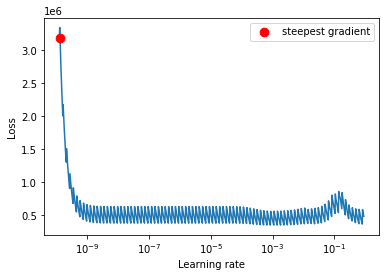

In [ ]:


import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import init
from torch_lr_finder import LRFinder


class ResistorDataset(Dataset):
    def __init__(self, resistor_data, voltages, type):
        self.resistor_data = resistor_data
        self.voltages = voltages
        self.type = type

    def __len__(self):
        return len(self.voltages) * 11  # 每个电压有11个input_2

    def __getitem__(self, idx):
        voltage_idx = idx // 11  # 计算电压索引
        j = idx % 11  # 计算 j 索引

        voltage = str(self.voltages[voltage_idx])
        input_1 = self.resistor_data[voltage][self.type].iloc[:50].to_numpy().flatten()
        input_2 = self.resistor_data[voltage][self.type].iloc[:, j].to_numpy()
        target_input = self.resistor_data[voltage][self.type].iloc[50:, j].to_numpy()

        input_1 = torch.from_numpy(input_1).float()
        input_2 = torch.from_numpy(input_2).float()
        target_input = torch.from_numpy(target_input).float()

        #print("input_2",input_2)
        return input_1, input_2,j,target_input

from torch_lr_finder import LRFinder

from torch_lr_finder import LRFinder

class CustomLRFinder(LRFinder):
    def _move_to_device(self, tensor, non_blocking=True):
        return tensor.to(self.device, non_blocking=non_blocking)
    
    def _train_batch(self, train_iter, accumulation_steps, non_blocking_transfer=True):
        self.model.train()
        total_loss = None

        self.optimizer.zero_grad()

        for i in range(accumulation_steps):
            try:
                inputs, target_input = next(train_iter)
            except StopIteration:
                return -1

            # 解包 inputs
            inputs1, inputs2,j = inputs
           
            inputs1=inputs1.view(-1)
            inputs2=inputs2.view(-1)
            j=j.view(-1)

            #print("inputs1 s",inputs1.shape)
            #print("inputs2 s",inputs2.shape)
            # 移動數據到設備上
            inputs1 = self._move_to_device(inputs1, non_blocking=non_blocking_transfer)
            inputs2 = self._move_to_device(inputs2, non_blocking=non_blocking_transfer)
            target_input = self._move_to_device(target_input, non_blocking=non_blocking_transfer)

            # 前向傳播
            outputs = self.model(inputs1, inputs2,j)
            loss = self.criterion(outputs, target_input)

            # 平均損失
            loss /= accumulation_steps

            # 反向傳播
            loss.backward()

            if total_loss is None:
                total_loss = loss.detach().item()
            else:
                total_loss += loss.detach().item()

        self.optimizer.step()

        return total_loss




       



# Initialize and wrap the model
model = CompleteModel()

# Define voltages and create dataset and dataloaders
voltages = list(range(1, 14))  # 从1到13的电压值
type = 'a'

train_dataset = ResistorDataset(resistor_data, voltages=voltages[:-1], type=type)  # 使用1-12的电压作为训练集
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
'''
for input_1, input_2,t in train_loader:
    print("input_1",input_1)
    print("input_2",input_2)
    print("t",t)
'''
test_dataset = ResistorDataset(resistor_data, voltages=[13], type=type)  # 使用13的电压作为测试集
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize model parameters
device = torch.device("cuda:0")
print(model)
for params in model.parameters():
    #print(params)
    init.normal_(params, mean=0, std=0.01)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Use torch-lr-finder to find optimal learning rate
# 使用自定義的 LRFinder
class DataLoaderWrapper(torch.utils.data.DataLoader):
    def __iter__(self):
        for idx, batch in enumerate(super().__iter__()):
            # 構建符合 (inputs, targets) 結構的批次數據
            inputs = (batch[0], batch[1], batch[2])
            targets = batch[3]
            
            #print(f"DataLoaderWrapper output - Index: {idx}, Inputs Length: {len(inputs)}, Targets Shape: {targets.shape}")
            
            yield inputs, targets

lr_finder = CustomLRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(DataLoaderWrapper(test_dataset),start_lr=1e-10, end_lr=1, num_iter=1000)
#lr_finder.range_test(test_loader, end_lr=1, num_iter=100)
lr_finder.plot()  # 显示损失函数与学习率的关系图
lr_finder.reset()  # 重置模型和优化器到初始状态
